# Descripción del proyecto
A la cadena de supermercados Good Seed le gustaría explorar si la ciencia de los datos puede ayudarle a cumplir con las leyes sobre el alcohol, al asegurarse de no vender alcohol a personas menores de edad. Te piden que hagas esa evaluación, así que, cuando te pongas a trabajar, ten en cuenta lo siguiente:

Las tiendas están equipadas con cámaras en el área de pago, las cuales se activan cuando una persona está comprando alcohol.
Los métodos de visión artificial se pueden usar para determinar la edad de una persona a partir de una foto.
La tarea, entonces, es construir y evaluar un modelo para verificar la edad de las personas.
Para empezar a trabajar en la tarea, tendrás un conjunto de fotografías de personas que indican su edad.

## Inicialización

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Carga los datos

El conjunto de datos se almacena en la carpeta `/datasets/faces/` 
- La carpeta `final_files` con 7600 fotos 
- El archivo `labels.csv` con etiquetas, con dos columnas: `file_name` y `real_age` 
Dado que el número de archivos de imágenes es bastante elevado, se recomienda evitar leerlos todos a la vez, ya que esto consumiría muchos recursos computacionales. Te recomendamos crear un generador con ImageDataGenerator. Este método se explicó en el capítulo 3, lección 7 de este curso.

El archivo de etiqueta se puede cargar como un archivo CSV habitual.

In [2]:
# Ruta a la carpeta de imágenes y al archivo de etiquetas
image_folder = '/datasets/faces/final_files'
labels_file = '/datasets/faces/labels.csv'

In [3]:
labels_df = pd.read_csv(labels_file)

In [4]:
labels_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [5]:
labels_df.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [6]:
# Tamaño del conjunto de datos:
# Observa el tamaño del conjunto de datos
print(f'Tamaño del conjunto de datos: {labels_df.shape[0]} imágenes')

Tamaño del conjunto de datos: 7591 imágenes


## EDA

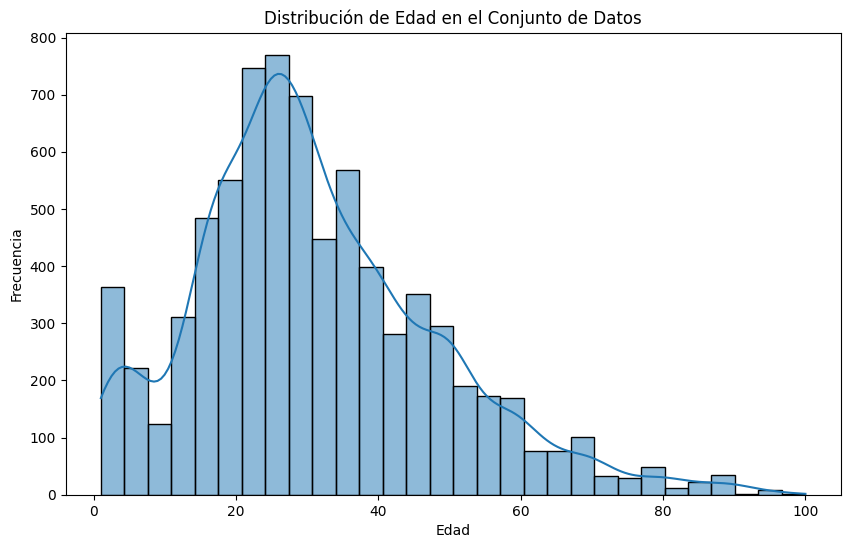

In [7]:
# histograma que muestra la distribución de las edades en el conjunto de datos.
# Explora la distribución de edad en el conjunto de datos
plt.figure(figsize=(10, 6))
sns.histplot(labels_df['real_age'], bins=30, kde=True)
plt.title('Distribución de Edad en el Conjunto de Datos')
plt.xlabel('Edad')
plt.ylabel('Frecuencia')
plt.show()

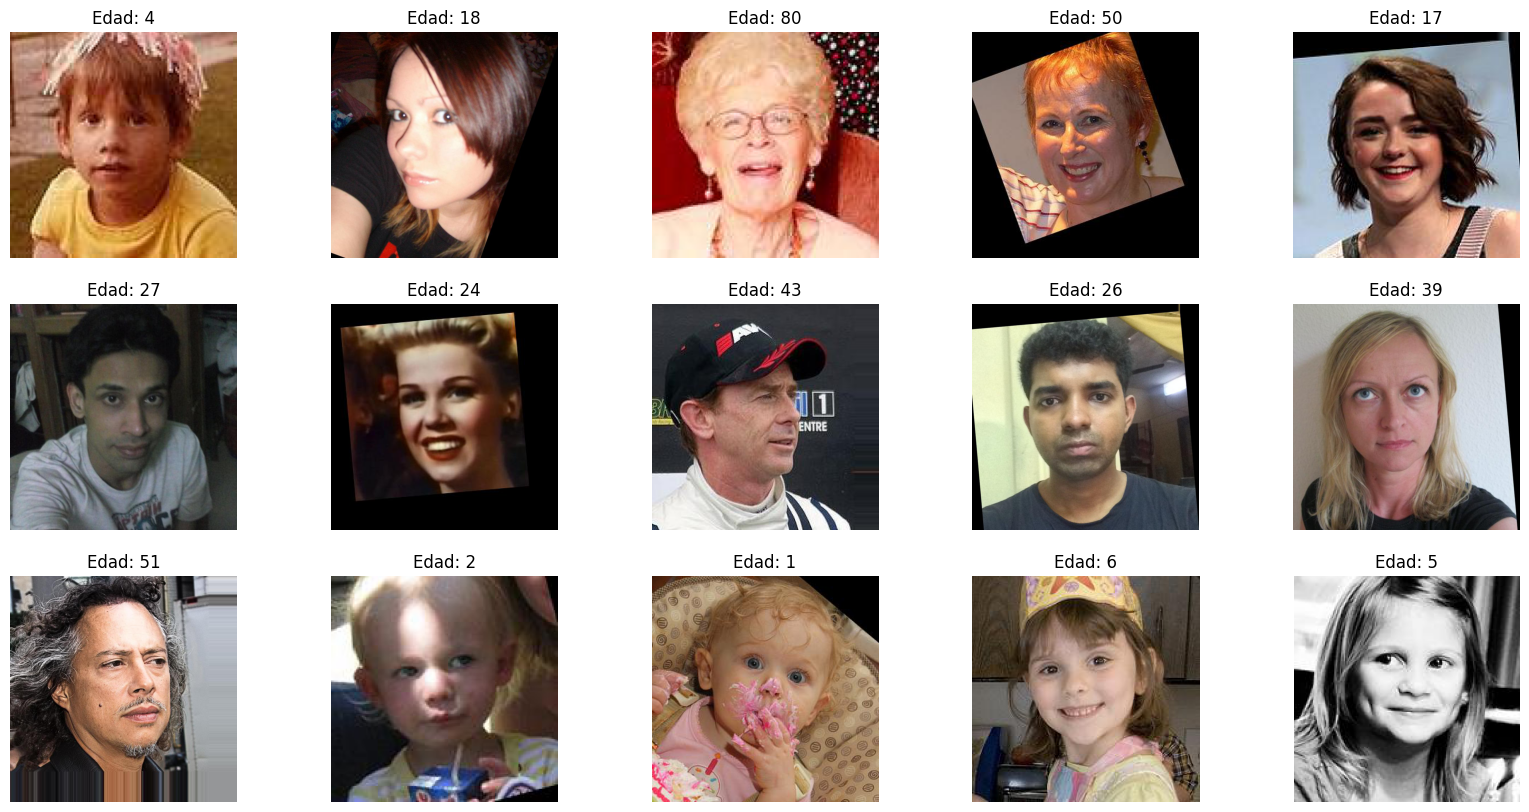

In [8]:
# Visualización de imágenes:
# Imprime de 10 a 15 fotos para diferentes edades
def show_images_for_ages(df, image_folder, num_images=15):
    unique_ages = df['real_age'].unique()
    selected_ages = unique_ages[:num_images]  # Selecciona las primeras edades únicas
    plt.figure(figsize=(20, 10))
    for i, age in enumerate(selected_ages):
        image_name = df[df['real_age'] == age]['file_name'].values[0]
        image_path = os.path.join(image_folder, image_name)
        image = Image.open(image_path)
        plt.subplot(3, 5, i + 1)
        plt.imshow(image)
        plt.title(f'Edad: {age}')
        plt.axis('off')
    plt.show()

show_images_for_ages(labels_df, image_folder, num_images=15)

### Conclusiones

- Diversidad de Datos: La variedad en las edades y la cantidad de imágenes sugieren que el conjunto de datos es robusto 
    y diverso, lo cual es beneficioso para el entrenamiento de modelos de clasificación de imágenes.
    
- Calidad de Datos: La visualización de las imágenes permite una inspección rápida de la calidad de los datos. 
    Si todas las imágenes parecen correctas y bien etiquetadas, esto es un buen indicio de que el conjunto de 
    datos está bien preparado para el entrenamiento.
    
- Distribución de Edades: Si la distribución de edades es equilibrada, el modelo tendrá más facilidad para aprender 
    a predecir correctamente las edades. Si no es equilibrada, podrías necesitar técnicas adicionales para balancear los datos.

## Modelado

Define las funciones necesarias para entrenar tu modelo en la plataforma GPU y crea un solo script que las contenga todas junto con la sección de inicialización.

Para facilitar esta tarea, puedes definirlas en este notebook y ejecutar un código listo en la siguiente sección para componer automáticamente el script.

Los revisores del proyecto también verificarán las definiciones a continuación, para que puedan comprender cómo construiste el modelo.

In [9]:
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

In [10]:
# Función para cargar los datos de entrenamiento:
def load_train(path):
    """
    Carga la parte de entrenamiento del conjunto de datos desde la ruta.
    """
    labels_file = f'{path}/labels.csv'
    image_folder = f'{path}/final_files'
    
    # Leer el archivo de etiquetas
    labels_df = pd.read_csv(labels_file)
    
    # Crear un generador de datos de imágenes con rescale
    train_datagen = ImageDataGenerator(rescale=1./255)
    
    # Crear un flujo de datos desde el dataframe
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels_df,
        directory=image_folder,
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345
    )
    
    return train_gen_flow

In [11]:
# Función para cargar los datos de validación/prueba
def load_test(path):
    """
    Carga la parte de validación/prueba del conjunto de datos desde la ruta.
    """
    labels_file = f'{path}/labels.csv'
    image_folder = f'{path}/final_files'
    
    # Leer el archivo de etiquetas
    labels_df = pd.read_csv(labels_file)
    
    # Crear un generador de datos de imágenes con rescale
    test_datagen = ImageDataGenerator(rescale=1./255)
    

    # Crear un flujo de datos desde el dataframe
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels_df,
        directory=image_folder,
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345
    )
    
    return test_gen_flow

In [12]:
# Función para crear el modelo:
def create_model(input_shape):
    """
    Crea y compila el modelo de red neuronal.
    """
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(1, activation='linear')
    ])
    
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    
    return model

In [13]:
# Función para entrenar el modelo:
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    """
    Entrena el modelo dados los parámetros
    """
    
    model = model.fit(train_data, epochs=epochs, verbose=1)
    
    return model

## Prepara el script para ejecutarlo en la plataforma GPU

Una vez que hayas definido las funciones necesarias, puedes redactar un script para la plataforma GPU, descargarlo a través del menú "File|Open..." (Archivo|Abrir) y cargarlo más tarde para ejecutarlo en la plataforma GPU.

Nota: el script debe incluir también la sección de inicialización. A continuación se muestra un ejemplo.

In [14]:
# prepara un script para ejecutarlo en la plataforma GPU

init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

In [15]:
# learning_rate=0.00001
# learning_rate=1e-5 (4)
# learning_rate=0.0001es igual a learning_rate=1e-4

In [16]:
import tensorflow as tf

# Verificar si TensorFlow está utilizando una GPU
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  0


In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import pandas as pd
import numpy as np

# Ruta a la carpeta de imágenes y al archivo de etiquetas
image_folder = '/datasets/faces/final_files'
labels_file = '/datasets/faces/labels.csv'

# Cargar las etiquetas
labels_df = pd.read_csv(labels_file)

# Definir el generador de datos con aumento de datos
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Crear un generador de datos personalizado para cargar las imágenes y las etiquetas
def custom_data_generator(image_folder, labels_df, batch_size=32, target_size=(224, 224), subset='training'):
    while True:
        if subset == 'training':
            df = labels_df.sample(frac=0.8, random_state=42)
        else:
            df = labels_df.drop(labels_df.sample(frac=0.8, random_state=42).index)
        for start in range(0, len(df), batch_size):
            end = min(start + batch_size, len(df))
            batch_images = []
            batch_labels = []
            for i in range(start, end):
                img_path = f"{image_folder}/{df.iloc[i]['file_name']}"
                img = load_img(img_path, target_size=target_size)
                img_array = img_to_array(img)
                img_array = datagen.standardize(img_array)
                batch_images.append(img_array)
                batch_labels.append(df.iloc[i]['real_age'])
            yield (np.array(batch_images), np.array(batch_labels))

# Crear los generadores de datos de entrenamiento y validación
train_data = custom_data_generator(image_folder, labels_df, subset='training')
val_data = custom_data_generator(image_folder, labels_df, subset='validation')

# Definir la arquitectura del modelo utilizando ResNet50 como base
base_model = ResNet50(input_shape=(224, 224, 3), weights='imagenet', include_top=False)
base_model.trainable = True
for layer in base_model.layers[:-10]:
    layer.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)), 
    Dropout(0.5),
    Dense(1, activation='linear')
])

# Compilar el modelo con una tasa de aprendizaje ajustada
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='mean_absolute_error', metrics=['mean_absolute_error'])

# Entrenar el modelo
history = model.fit(train_data, validation_data=val_data, epochs=20, steps_per_epoch=len(labels_df) // 32, validation_steps=len(labels_df) // 32)


oloca el resultado de la plataforma GPU como una celda Markdown aquí.

Mejorar el MAE

- Epoch 1/20
237/237 [==============================] - 3353s 14s/step - loss: 14.1954 - mean_absolute_error: 14.1256 - val_loss: 12.7645 - val_mean_absolute_error: 12.7032
- Epoch 2/20
237/237 [==============================] - 3303s 14s/step - loss: 12.5479 - mean_absolute_error: 12.4902 - val_loss: 20.2588 - val_mean_absolute_error: 20.2035
- Epoch 3/20
237/237 [==============================] - 3313s 14s/step - loss: 12.0900 - mean_absolute_error: 12.0361 - val_loss: 13.4925 - val_mean_absolute_error: 13.4397
- Epoch 4/20
237/237 [==============================] - 3258s 14s/step - loss: 11.9369 - mean_absolute_error: 11.8850 - val_loss: 12.6172 - val_mean_absolute_error: 12.5661
- Epoch 5/20
237/237 [==============================] - 3274s 14s/step - loss: 11.5088 - mean_absolute_error: 11.4586 - val_loss: 16.7068 - val_mean_absolute_error: 16.6574
- Epoch 6/20
237/237 [==============================] - 3302s 14s/step - loss: 11.3600 - mean_absolute_error: 11.3112 - val_loss: 14.4511 - val_mean_absolute_error: 14.4030
- Epoch 7/20
237/237 [==============================] - 3291s 14s/step - loss: 11.0206 - mean_absolute_error: 10.9731 - val_loss: 12.0506 - val_mean_absolute_error: 12.0037
- Epoch 8/20
237/237 [==============================] - 3287s 14s/step - loss: 11.0611 - mean_absolute_error: 11.0147 - val_loss: 30.6612 - val_mean_absolute_error: 30.6154
- Epoch 9/20
237/237 [==============================] - 3336s 14s/step - loss: 10.6827 - mean_absolute_error: 10.6374 - val_loss: 14.8948 - val_mean_absolute_error: 14.8500
- Epoch 10/20
237/237 [==============================] - 3265s 14s/step - loss: 10.5217 - mean_absolute_error: 10.4773 - val_loss: 11.8663 - val_mean_absolute_error: 11.8223
- Epoch 11/20
237/237 [==============================] - 3322s 14s/step - loss: 10.1952 - mean_absolute_error: 10.1517 - val_loss: 23.6971 - val_mean_absolute_error: 23.6540
- Epoch 12/20
237/237 [==============================] - 3353s 14s/step - loss: 10.1642 - mean_absolute_error: 10.1215 - val_loss: 39.5111 - val_mean_absolute_error: 39.4688
- Epoch 13/20
237/237 [==============================] - 3341s 14s/step - loss: 9.8429 - mean_absolute_error: 9.8010 - val_loss: 25.2069 - val_mean_absolute_error: 25.1653
- Epoch 14/20
237/237 [==============================] - 3324s 14s/step - loss: 9.7879 - mean_absolute_error: 9.7466 - val_loss: 20.1761 - val_mean_absolute_error: 20.1351
- Epoch 15/20
237/237 [==============================] - 3327s 14s/step - loss: 9.5204 - mean_absolute_error: 9.4798 - val_loss: 12.2501 - val_mean_absolute_error: 12.2098
- Epoch 16/20
237/237 [==============================] - 3327s 14s/step - loss: 9.5472 - mean_absolute_error: 9.5071 - val_loss: 83.4052 - val_mean_absolute_error: 83.3656
- Epoch 17/20
237/237 [==============================] - 3326s 14s/step - loss: 9.1367 - mean_absolute_error: 9.0973 - val_loss: 12.6067 - val_mean_absolute_error: 12.5676
- Epoch 18/20
237/237 [==============================] - 3340s 14s/step - loss: 9.0533 - mean_absolute_error: 9.0145 - val_loss: 15.0021 - val_mean_absolute_error: 14.9635
- Epoch 19/20
237/237 [==============================] - 3317s 14s/step - loss: 8.9309 - mean_absolute_error: 8.8926 - val_loss: 14.8970 - val_mean_absolute_error: 14.8590
- Epoch 20/20
237/237 [==============================] - 3366s 14s/step - loss: 9.0000 - mean_absolute_error: 8.9622 - val_loss: 13.3367 - val_mean_absolute_error: 13.2991

In [17]:
# Resultado N°2 Probar eliminando el sobreajuste Dropout(0.5)

In [18]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import pandas as pd
import numpy as np

# Ruta a la carpeta de imágenes y al archivo de etiquetas
image_folder = '/datasets/faces/final_files'
labels_file = '/datasets/faces/labels.csv'

# Cargar las etiquetas
labels_df = pd.read_csv(labels_file)

# Definir el generador de datos con aumento de datos
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Crear un generador de datos personalizado para cargar las imágenes y las etiquetas
def custom_data_generator(image_folder, labels_df, batch_size=32, target_size=(224, 224), subset='training'):
    while True:
        if subset == 'training':
            df = labels_df.sample(frac=0.8, random_state=42)
        else:
            df = labels_df.drop(labels_df.sample(frac=0.8, random_state=42).index)
        for start in range(0, len(df), batch_size):
            end = min(start + batch_size, len(df))
            batch_images = []
            batch_labels = []
            for i in range(start, end):
                img_path = f"{image_folder}/{df.iloc[i]['file_name']}"
                img = load_img(img_path, target_size=target_size)
                img_array = img_to_array(img)
                img_array = datagen.standardize(img_array)
                batch_images.append(img_array)
                batch_labels.append(df.iloc[i]['real_age'])
            yield (np.array(batch_images), np.array(batch_labels))

# Crear los generadores de datos de entrenamiento y validación
train_data = custom_data_generator(image_folder, labels_df, subset='training')
val_data = custom_data_generator(image_folder, labels_df, subset='validation')

# Definir la arquitectura del modelo utilizando ResNet50 como base
base_model = ResNet50(input_shape=(224, 224, 3), weights='imagenet', include_top=False)
base_model.trainable = True
for layer in base_model.layers[:-10]:
    layer.trainable = False

# Crear el modelo secuencial sin Dropout
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(1, activation='linear'))

# Compilar el modelo con una tasa de aprendizaje ajustada
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='mean_absolute_error', metrics=['mean_absolute_error'])

# Entrenar el modelo
history = model.fit(train_data, validation_data=val_data, epochs=20, steps_per_epoch=len(labels_df) // 32, validation_steps=len(labels_df) // 32)


Epoch 1/20
237/237 [==============================] - 3340s 14s/step - loss: 18.7385 - mean_absolute_error: 18.7385 - val_loss: 16.1314 - val_mean_absolute_error: 16.1314
Epoch 2/20
237/237 [==============================] - 3362s 14s/step - loss: 13.5488 - mean_absolute_error: 13.5488 - val_loss: 14.5305 - val_mean_absolute_error: 14.5305
Epoch 3/20
237/237 [==============================] - 3336s 14s/step - loss: 12.1856 - mean_absolute_error: 12.1856 - val_loss: 12.9410 - val_mean_absolute_error: 12.9410
Epoch 4/20
237/237 [==============================] - 3317s 14s/step - loss: 11.9648 - mean_absolute_error: 11.9648 - val_loss: 12.6688 - val_mean_absolute_error: 12.6688
Epoch 5/20
237/237 [==============================] - 3290s 14s/step - loss: 11.2555 - mean_absolute_error: 11.2555 - val_loss: 14.4499 - val_mean_absolute_error: 14.4499
Epoch 6/20
237/237 [==============================] - 3318s 14s/step - loss: 11.0727 - mean_absolute_error: 11.0727 - val_loss: 11.7104 - val_mea

- Epoch 1/20
237/237 [==============================] - 3340s 14s/step - loss: 18.7385 - mean_absolute_error: 18.7385 - val_loss: 16.1314 - val_mean_absolute_error: 16.1314
- Epoch 2/20
237/237 [==============================] - 3362s 14s/step - loss: 13.5488 - mean_absolute_error: 13.5488 - val_loss: 14.5305 - val_mean_absolute_error: 14.5305
- Epoch 3/20
237/237 [==============================] - 3336s 14s/step - loss: 12.1856 - mean_absolute_error: 12.1856 - val_loss: 12.9410 - val_mean_absolute_error: 12.9410
- Epoch 4/20
237/237 [==============================] - 3317s 14s/step - loss: 11.9648 - mean_absolute_error: 11.9648 - val_loss: 12.6688 - val_mean_absolute_error: 12.6688
- Epoch 5/20
237/237 [==============================] - 3290s 14s/step - loss: 11.2555 - mean_absolute_error: 11.2555 - val_loss: 14.4499 - val_mean_absolute_error: 14.4499
- Epoch 6/20
237/237 [==============================] - 3318s 14s/step - loss: 11.0727 - mean_absolute_error: 11.0727 - val_loss: 11.7104 - val_mean_absolute_error: 11.7104
- Epoch 7/20
237/237 [==============================] - 3325s 14s/step - loss: 10.6529 - mean_absolute_error: 10.6529 - val_loss: 12.3614 - val_mean_absolute_error: 12.3614
- Epoch 8/20
237/237 [==============================] - 3336s 14s/step - loss: 10.6047 - mean_absolute_error: 10.6047 - val_loss: 18.1906 - val_mean_absolute_error: 18.1906
- Epoch 9/20
237/237 [==============================] - 3344s 14s/step - loss: 10.1750 - mean_absolute_error: 10.1750 - val_loss: 11.7231 - val_mean_absolute_error: 11.7231
- Epoch 10/20
237/237 [==============================] - 3320s 14s/step - loss: 10.0174 - mean_absolute_error: 10.0174 - val_loss: 13.7016 - val_mean_absolute_error: 13.7016
- Epoch 11/20
237/237 [==============================] - 3325s 14s/step - loss: 9.6587 - mean_absolute_error: 9.6587 - val_loss: 24.1666 - val_mean_absolute_error: 24.1666
- Epoch 12/20
237/237 [==============================] - 3326s 14s/step - loss: 9.6788 - mean_absolute_error: 9.6788 - val_loss: 14.6505 - val_mean_absolute_error: 14.6505
- Epoch 13/20
237/237 [==============================] - 3231s 14s/step - loss: 9.3399 - mean_absolute_error: 9.3399 - val_loss: 11.4261 - val_mean_absolute_error: 11.4261
- Epoch 14/20
237/237 [==============================] - 2784s 12s/step - loss: 9.2435 - mean_absolute_error: 9.2435 - val_loss: 14.3786 - val_mean_absolute_error: 14.3786
- Epoch 15/20
237/237 [==============================] - 3104s 13s/step - loss: 8.9399 - mean_absolute_error: 8.9399 - val_loss: 19.9051 - val_mean_absolute_error: 19.9051
- Epoch 16/20
237/237 [==============================] - 3222s 14s/step - loss: 9.0739 - mean_absolute_error: 9.0739 - val_loss: 42.4016 - val_mean_absolute_error: 42.4016
- Epoch 17/20
237/237 [==============================] - 3004s 13s/step - loss: 8.7628 - mean_absolute_error: 8.7628 - val_loss: 12.1703 - val_mean_absolute_error: 12.1703
- Epoch 18/20
237/237 [==============================] - 3038s 13s/step - loss: 8.6214 - mean_absolute_error: 8.6214 - val_loss: 12.1790 - val_mean_absolute_error: 12.1790
- Epoch 19/20
237/237 [==============================] - 3019s 13s/step - loss: 8.4415 - mean_absolute_error: 8.4415 - val_loss: 12.2706 - val_mean_absolute_error: 12.2706
- Epoch 20/20
237/237 [==============================] - 3056s 13s/step - loss: 8.4229 - mean_absolute_error: 8.4229 - val_loss: 15.9426 - val_mean_absolute_error: 15.9426

### El resultado

Coloca el resultado de la plataforma GPU como una celda Markdown aquí.
- Resultado N°2 Probar eliminando el sobreajuste Dropout(0.5)

Mejorar el MAE

- Epoch 1/20
237/237 [==============================] - 3340s 14s/step - loss: 18.7385 - mean_absolute_error: 18.7385 - val_loss: 16.1314 - val_mean_absolute_error: 16.1314
- Epoch 2/20
237/237 [==============================] - 3362s 14s/step - loss: 13.5488 - mean_absolute_error: 13.5488 - val_loss: 14.5305 - val_mean_absolute_error: 14.5305
- Epoch 3/20
237/237 [==============================] - 3336s 14s/step - loss: 12.1856 - mean_absolute_error: 12.1856 - val_loss: 12.9410 - val_mean_absolute_error: 12.9410
- Epoch 4/20
237/237 [==============================] - 3317s 14s/step - loss: 11.9648 - mean_absolute_error: 11.9648 - val_loss: 12.6688 - val_mean_absolute_error: 12.6688
- Epoch 5/20
237/237 [==============================] - 3290s 14s/step - loss: 11.2555 - mean_absolute_error: 11.2555 - val_loss: 14.4499 - val_mean_absolute_error: 14.4499
- Epoch 6/20
237/237 [==============================] - 3318s 14s/step - loss: 11.0727 - mean_absolute_error: 11.0727 - val_loss: 11.7104 - val_mean_absolute_error: 11.7104
- Epoch 7/20
237/237 [==============================] - 3325s 14s/step - loss: 10.6529 - mean_absolute_error: 10.6529 - val_loss: 12.3614 - val_mean_absolute_error: 12.3614
- Epoch 8/20
237/237 [==============================] - 3336s 14s/step - loss: 10.6047 - mean_absolute_error: 10.6047 - val_loss: 18.1906 - val_mean_absolute_error: 18.1906
- Epoch 9/20
237/237 [==============================] - 3344s 14s/step - loss: 10.1750 - mean_absolute_error: 10.1750 - val_loss: 11.7231 - val_mean_absolute_error: 11.7231
- Epoch 10/20
237/237 [==============================] - 3320s 14s/step - loss: 10.0174 - mean_absolute_error: 10.0174 - val_loss: 13.7016 - val_mean_absolute_error: 13.7016
- Epoch 11/20
237/237 [==============================] - 3325s 14s/step - loss: 9.6587 - mean_absolute_error: 9.6587 - val_loss: 24.1666 - val_mean_absolute_error: 24.1666
- Epoch 12/20
237/237 [==============================] - 3326s 14s/step - loss: 9.6788 - mean_absolute_error: 9.6788 - val_loss: 14.6505 - val_mean_absolute_error: 14.6505
- Epoch 13/20
237/237 [==============================] - 3231s 14s/step - loss: 9.3399 - mean_absolute_error: 9.3399 - val_loss: 11.4261 - val_mean_absolute_error: 11.4261
- Epoch 14/20
237/237 [==============================] - 2784s 12s/step - loss: 9.2435 - mean_absolute_error: 9.2435 - val_loss: 14.3786 - val_mean_absolute_error: 14.3786
- Epoch 15/20
237/237 [==============================] - 3104s 13s/step - loss: 8.9399 - mean_absolute_error: 8.9399 - val_loss: 19.9051 - val_mean_absolute_error: 19.9051
- Epoch 16/20
237/237 [==============================] - 3222s 14s/step - loss: 9.0739 - mean_absolute_error: 9.0739 - val_loss: 42.4016 - val_mean_absolute_error: 42.4016
- Epoch 17/20
237/237 [==============================] - 3004s 13s/step - loss: 8.7628 - mean_absolute_error: 8.7628 - val_loss: 12.1703 - val_mean_absolute_error: 12.1703
- Epoch 18/20
237/237 [==============================] - 3038s 13s/step - loss: 8.6214 - mean_absolute_error: 8.6214 - val_loss: 12.1790 - val_mean_absolute_error: 12.1790
- Epoch 19/20
237/237 [==============================] - 3019s 13s/step - loss: 8.4415 - mean_absolute_error: 8.4415 - val_loss: 12.2706 - val_mean_absolute_error: 12.2706
- Epoch 20/20
237/237 [==============================] - 3056s 13s/step - loss: 8.4229 - mean_absolute_error: 8.4229 - val_loss: 15.9426 - val_mean_absolute_error: 15.9426

## Conclusiones

- Para mejorar el modelo y lograr que el MAE (Mean Absolute Error) sea igual o menor a 8, intente ajustar algunos parámetros y técnicas. Tales como:

- Aumentar el número de épocas: Entrenar el modelo por más tiempo puede ayudar a mejorar su precisión.
- Ajustar la tasa de aprendizaje: Una tasa de aprendizaje demasiado baja puede hacer que el modelo tarde mucho en converger. Puedes probar con una tasa de aprendizaje un poco más alta, como 0.00001.
- Aumentar la complejidad del modelo: Agregar más capas o neuronas puede ayudar a que el modelo capture mejor las características de los datos.
- Regularización: Añadir técnicas de regularización como Dropout o L2 regularization para evitar el sobreajuste.
Aumento de datos: Asegúrate de que el aumento de datos sea adecuado y no esté introduciendo ruido innecesario.</b> <a 

- ¿Puede la visión artificial ayudar al cliente en este caso? 
    
    Sí, la visión artificial puede ser muy útil en este caso. Un modelo de predicción de edad a partir de imágenes puede ayudar al cliente en diversas aplicaciones, como en la verificación de edad en sistemas de seguridad, personalización de contenido en plataformas digitales, y análisis demográfico en estudios de mercado.
    
    
- ¿Qué otras tareas prácticas podría resolver el cliente con el modelo?

    - Detección de emociones: El modelo podría adaptarse para reconocer emociones en las caras, lo que puede ser útil en atención al cliente y análisis de comportamiento.
    - Reconocimiento facial: Ampliando el modelo, se podría utilizar para identificar personas en sistemas de seguridad y control de acceso.
    - Análisis de salud: Evaluar características faciales para detectar signos de ciertas condiciones de salud, como el envejecimiento prematuro o el estrés

# Lista de control

- [x]  El Notebook estaba abierto 
- [x]  El código no tiene errores
- [x]  Las celdas con el código han sido colocadas en el orden de ejecución
- [x]  Se realizó el análisis exploratorio de datos 
- [x]  Los resultados del análisis exploratorio de datos se presentan en el notebook final 
- [x]  El valor EAM del modelo no es superior a 8 
- [x]  El código de entrenamiento del modelo se copió en el notebook final 
- [x]  El resultado de entrenamiento del modelo se copió en el notebook final 
- [x] Los hallazgos se proporcionaron con base en los resultados del entrenamiento del modelo